In [1]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
import hdbscan
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import *
from importlib import reload

import utils
import lvutils as lv
import mattplotlib as m

def redo():
    reload(utils)
    reload(lv)
    reload(m)
    reload(umap)

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

Invoking __init__.py for NDNT.utils


# Trying UMAP for manifold learning

In [2]:
data = utils.load_data('ki_0503_V2b_py.mat')
# load the saved out latents
model = utils.load_model('model_2_ki_0503_V2b_py.pickle')
R = utils.construct_R_matrix(data)
Z = utils.construct_Z_matrix(R, model, num_latents=3)
Z.shape # trials X time X latents

../../data/hn/ ki_0503_V2b_py.mat
Loaded ki_0503_V2b_py.mat
118679 frames, 31 units, 848 trials with 116 frames each
  Time embedding...
  Time embedding...


(848, 121, 3)

In [3]:
R.shape # trials X time X neurons

(848, 121, 31)

## Try seaborn pairplot to see relationships

In [4]:
# convert R to a pandas DataFrame
# collapse data along the time dimension (average across time)
means_across_time = pd.DataFrame(np.mean(R, axis=1))
means_across_trials = pd.DataFrame(np.mean(R, axis=0))

In [5]:
# NOTE: uncomment this to do it, it's super slow
# sns.pairplot(means_across_trials)

In [6]:
reducer = umap.UMAP()


# recompute only if it hasn't been done already, it's pretty slow
if not os.path.isfile('neuron_embeddings.pickle'):
    neuron_embeddings = []

    # fit the neurons over time and trials
    for i in range(R.shape[2]):
        scaled_R = StandardScaler().fit_transform(R[:,:,i])
        neuron_embedding = reducer.fit_transform(scaled_R)
        neuron_embeddings.append(neuron_embedding)

    # save them out
    with open('neuron_embeddings.pickle', 'wb') as f:
        pickle.dump(neuron_embeddings, f)
else: # load the pickle
    with open('neuron_embeddings.pickle', 'rb') as f:
        neuron_embeddings = pickle.load(f)

## embeddings for means across time

<Figure size 1008x720 with 0 Axes>

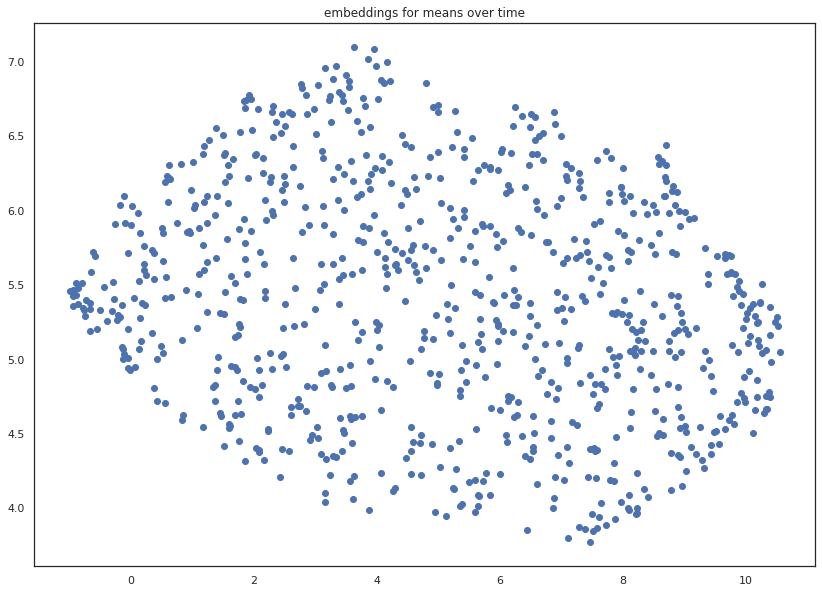

In [7]:
scaled_means = StandardScaler().fit_transform(means_across_time)
time_embedding = reducer.fit_transform(scaled_means)
m.fig()
plt.scatter(
    time_embedding[:, 0],
    time_embedding[:, 1])
plt.title('embeddings for means over time')
plt.show()

## try clustering the means across time using the umap thingy

In [8]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(means_across_time)

<Figure size 1008x720 with 0 Axes>

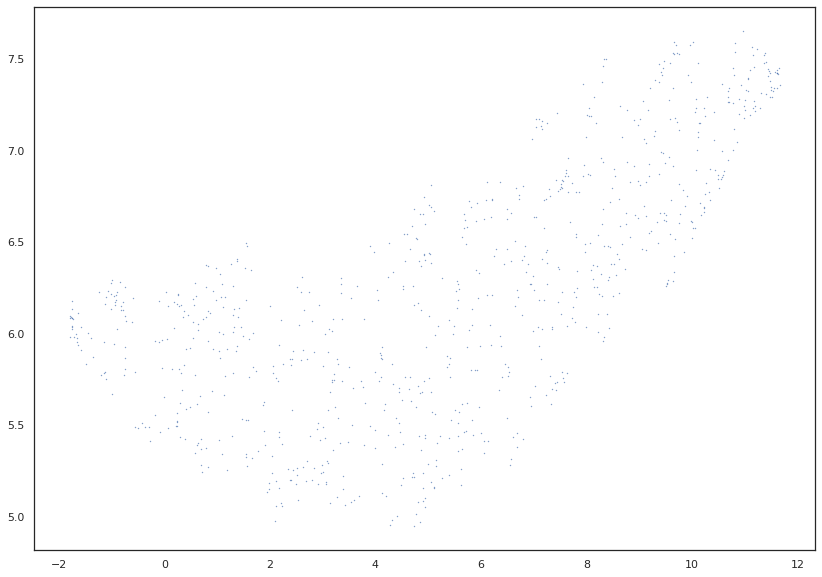

In [9]:
m.fig()
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')

In [10]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=10,
).fit_predict(clusterable_embedding)

<Figure size 1008x720 with 0 Axes>

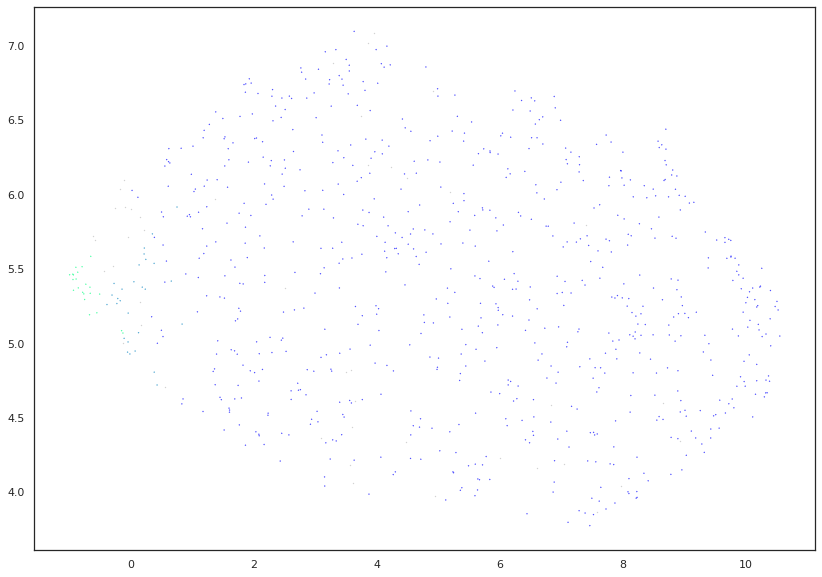

In [11]:
m.fig()
clustered = (labels >= 0)
plt.scatter(time_embedding[~clustered, 0],
            time_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(time_embedding[clustered, 0],
            time_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='winter')

In [12]:
utils.enpickle(labels, 'arms_labels_umap.pickle')

In [13]:
# subset points by labels and plot counts of trial vars for each
np.unique(labels)

array([-1,  0,  1,  2])

## plot all trial variables colored by their cluster

In [14]:
data.TRchoice.shape, labels[50:-49].shape, lv.movavg(data.TRchoice, 100).shape

((848,), (749,), (749,))

In [15]:
latent0 = np.mean(Z, axis=1).T[0]
latent1 = np.mean(Z, axis=1).T[1]
latent2 = np.mean(Z, axis=1).T[2]

trcorrect = (data.TRchoice == data.TRcued).astype(int)

# this tells us which side to look at for the experimental variables
sides = data.TRcued.copy() # copy the array so we don't corrupt the raw data
sides[sides == 1] = 0 # make all +1 sides index into column 0
sides[sides == -1] = 1 # make all the -1 sides index into column 1
trsignal = np.array([signal[side] for signal, side in zip(data.TRsignal, sides)])

ValueError: x and y must be the same size

<Figure size 1008x720 with 0 Axes>

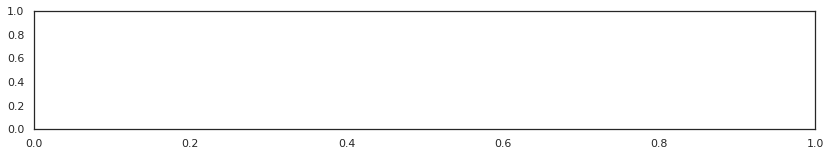

In [16]:
m.fig()
num_plots = 4
plt.subplot(num_plots, 1, 1)
plt.scatter(range(771), lv.movavg(data.TRchoice, 100), c=labels[50:-49], label="choice")
plt.legend()
plt.subplot(num_plots, 1, 2)
plt.scatter(range(771), lv.movavg(trcorrect, 100), c=labels[50:-49], label="correct")
plt.legend()
plt.subplot(num_plots, 1, 3)
plt.scatter(range(771), lv.movavg(trsignal, 100), c=labels[50:-49], label="signal")
plt.legend()
plt.subplot(num_plots, 1, 4)
plt.scatter(range(len(latent2)), latent2, c=labels, label="latent2")
plt.legend()
plt.show()

## embeddings for means across trials

In [ ]:
trial_embedding.shape

In [ ]:
scaled_means = StandardScaler().fit_transform(means_across_trials)
trial_embedding = reducer.fit_transform(scaled_means)
m.fig()
plt.scatter(
    trial_embedding[:, 0],
    trial_embedding[:, 1],
    c=range(0,200),
    cmap='winter')
plt.title('embeddings for means over trials')
plt.show()

## plot the neuron embeddings over time and trial per neuron

In [ ]:
m.fig()
fig, axs = plt.subplots(ncols=9, nrows=3, figsize=(54, 18), layout="constrained")

for row in range(3):
    for col in range(9):
        if row*3+col < len(neuron_embeddings):
            embedding = neuron_embeddings[row*3+col]
            axs[row,col].scatter(embedding[:,0], embedding[:,1], c=labels, cmap='winter')
plt.show()

In [ ]:
# TODO: cluster the neurons by their embedding similarity
# TODO: cluster the neurons by their temporal similarity
#       (maybe with Fourier transform and Discrete Wavelet Transform)
# https://umap-learn.readthedocs.io/en/latest/clustering.html
print('running')